In [6]:
import sys
sys.path.append("..")

# Reload modules in /src/ when changed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from fxml.trading.strategies.trendline_breakout.trendline_automation import fit_trendlines_single, fit_trendlines_high_low

In [8]:
# Load data
data = pd.read_pickle("../data/resampled/EURUSD-60m-20210101-20241231.pkl")
data["timestamp"] = data["timestamp"].astype("datetime64[s]")
data = data.set_index("timestamp")
data.head()

,open,high,low,close,volume,spread
timestamp,,,,,,
2021-01-03 22:00:00,1.224035,1.224260,1.223160,1.223435,3.329510e+12,0.000152
2021-01-03 23:00:00,1.223415,1.225280,1.223115,1.225015,1.089952e+13,0.000075
2021-01-04 00:00:00,1.225010,1.225010,1.223875,1.224080,1.429532e+13,0.000039
2021-01-04 01:00:00,1.224090,1.225580,1.224000,1.225270,1.800660e+13,0.000039
2021-01-04 02:00:00,1.225265,1.225865,1.224955,1.225400,1.490831e+13,0.000037


In [20]:
def trendline_breakout(close: np.array, lookback:int):
    s_tl = np.zeros(len(close))
    s_tl[:] = np.nan

    r_tl = np.zeros(len(close))
    r_tl[:] = np.nan

    sig = np.zeros(len(close))

    for i in range(lookback, len(close)):
        # NOTE window does NOT include the current candle

        close_window = close[i - lookback: i]

        s_coefs, r_coefs = fit_trendlines_single(close_window)

        # Find current value of line, projected forward to current bar
        s_val = s_coefs[1] + lookback * s_coefs[0] 
        r_val = r_coefs[1] + lookback * r_coefs[0] 

        s_tl[i] = s_val
        r_tl[i] = r_val

        if close[i] > r_val:
            sig[i] = 1.0
        elif close[i] < s_val:
            sig[i] = -1.0
        else:
            sig[i] = sig[i - 1]

    return s_tl, r_tl, sig

Profit Factor 24 0.9829386394960904
Profit Factor 26 0.9810858412447794
Profit Factor 28 0.9756871726782533
Profit Factor 30 0.9741066597526828
Profit Factor 32 0.9795986291105916
Profit Factor 34 0.9921262149140582
Profit Factor 36 0.9895578133406713
Profit Factor 38 0.9917878049968633
Profit Factor 40 0.989147477471377
Profit Factor 42 0.9854619566640633
Profit Factor 44 0.9887189684866814
Profit Factor 46 0.9893640340694265
Profit Factor 48 0.9908687829426576
Profit Factor 50 0.9913834731630978
Profit Factor 52 0.9956760372814693
Profit Factor 54 0.9969034810858793
Profit Factor 56 0.9950542320436262
Profit Factor 58 0.9977107155049598
Profit Factor 60 1.013063293583345
Profit Factor 62 1.0176138592040112
Profit Factor 64 1.009171249171502
Profit Factor 66 1.0173684374794114
Profit Factor 68 1.0120797618793271
Profit Factor 70 1.006921558134964
Profit Factor 72 1.0127704940442
Profit Factor 74 1.0127325064503172
Profit Factor 76 1.0102147851093708
Profit Factor 78 1.0121752907116133

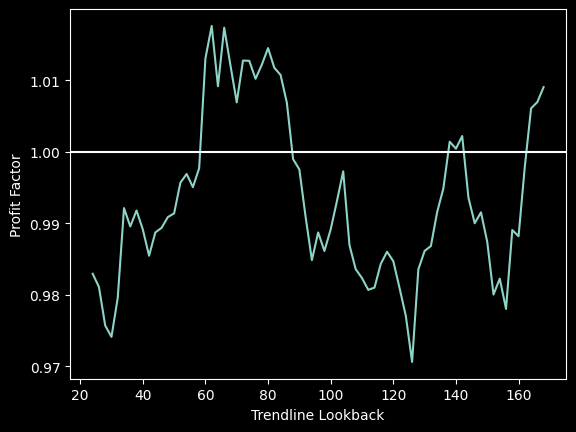

In [21]:
## Parameter Sweep

lookbacks = list(range(24, 169, 2))
pfs = []

lookback_returns = pd.DataFrame()
for lookback in lookbacks:
    support, resist, signal = trendline_breakout(data["close"].to_numpy(), lookback)
    data["signal"] = signal

    data["r"] = np.log(data["close"]).diff().shift(-1)
    strat_r = data["signal"] * data["r"]

    pf = strat_r[strat_r > 0].sum() / strat_r[strat_r < 0].abs().sum()
    print("Profit Factor", lookback, pf)
    pfs.append(pf)

    lookback_returns[lookback] = strat_r

plt.style.use("dark_background")
x = pd.Series(pfs, index=lookbacks)
x.plot()
plt.ylabel("Profit Factor")
plt.xlabel("Trendline Lookback")
plt.axhline(1.0, color="white")

In [22]:
lookback = 74

In [11]:
support, resist, signal = trendline_breakout(data["close"].to_numpy(), lookback)
data["support"] = support
data["resist"] = resist
data["signal"] = signal

Profit Factor 74 1.0321017810757913


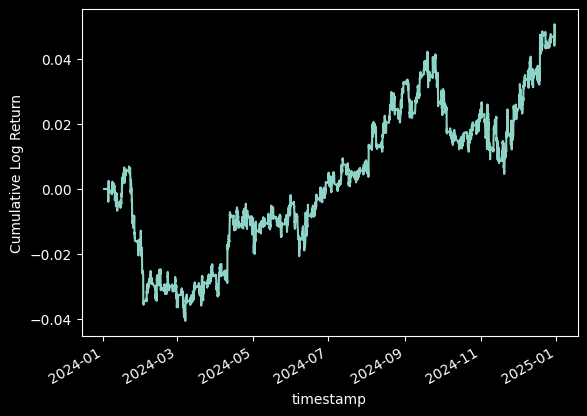

In [13]:
data["r"] = np.log(data["close"]).diff().shift(-1)
strat_r = data["signal"] * data["r"]

pf = strat_r[strat_r > 0].sum() / strat_r[strat_r < 0].abs().sum()
print("Profit Factor", lookback, pf)

strat_r.cumsum().plot()
plt.ylabel("Cumulative Log Return")
plt.show()

In [16]:
data[data["signal"] != data["signal"].shift()].index

DatetimeIndex(['2024-01-01 22:00:00', '2024-01-05 00:00:00',
               '2024-01-09 09:00:00', '2024-01-10 15:00:00',
               '2024-01-12 11:00:00', '2024-01-17 17:00:00',
               '2024-01-22 14:00:00', '2024-01-23 06:00:00',
               '2024-01-23 10:00:00', '2024-01-24 13:00:00',
               ...
               '2024-11-24 22:00:00', '2024-11-29 09:00:00',
               '2024-12-03 13:00:00', '2024-12-06 14:00:00',
               '2024-12-11 13:00:00', '2024-12-17 08:00:00',
               '2024-12-20 08:00:00', '2024-12-24 02:00:00',
               '2024-12-26 03:00:00', '2024-12-30 05:00:00'],
              dtype='datetime64[s]', name='timestamp', length=147, freq=None)